# Autoencoder for MNIST compared to supervised model

### Imports and load the MNIST dataset

In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


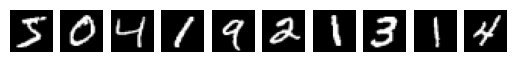

In [52]:
# Plot the first 10 images
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

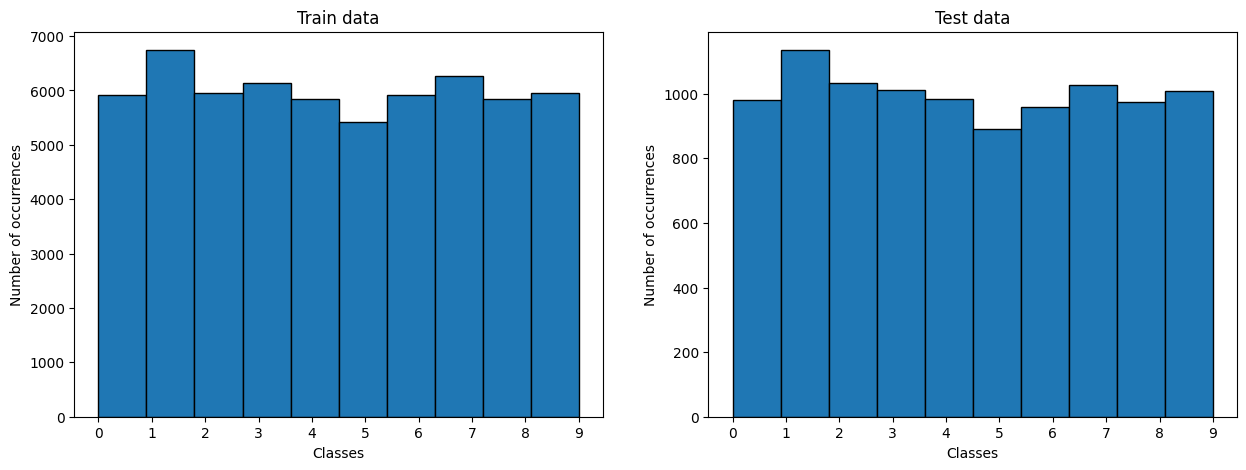

In [53]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
axs[0].hist(y_train, ec='black')
axs[0].set_title('Train data')
axs[0].set_xlabel('Classes') 
axs[0].set_ylabel('Number of occurrences')
axs[1].hist(y_test, ec='black')
axs[1].set_title('Test data')
axs[1].set_xlabel('Classes') 
axs[1].set_ylabel('Number of occurrences')
# We want to show all ticks...
axs[0].set_xticks(np.arange(10))
axs[1].set_xticks(np.arange(10))

plt.show()

### Vector size for latent variables and number of epochs

In [54]:
LATENT_SIZE = 32
EPOCHS = 10

### Define the autoencoder model consisting of an encoder and decoder

In [55]:
# Autoencoder using CNN layers
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(LATENT_SIZE, activation="relu")
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(7 * 7 * 32, input_shape=(LATENT_SIZE,)),
    tf.keras.layers.Reshape((7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same"),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same"),
    tf.keras.layers.Reshape((28, 28))
])

img = tf.keras.layers.Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
autoencoder = tf.keras.models.Model(inputs = img, outputs = output)

### Compile and train the autoencoder

In [56]:
autoencoder.compile("nadam", loss = "binary_crossentropy")

history = autoencoder.fit(x_train, x_train, epochs=EPOCHS)

Epoch 1/10
1875/1875 [==============================] - 34s 17ms/step - loss: 0.1187
Epoch 2/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0900
Epoch 3/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0866
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0850
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0839
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0831
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0824
Epoch 8/10
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0819
Epoch 9/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0815
Epoch 10/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0812


### Plot the autoencoder loss

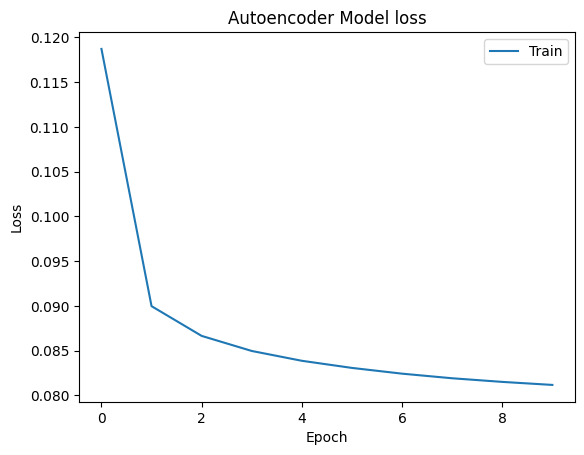

In [57]:
plt.plot(history.history['loss'])
plt.title('Autoencoder Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Fine-tune the model with supervised learning with 10% of the training data

In [62]:
# Set up the model
fine_tune_model = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
fine_tune_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Use 1% of the labeled training examples for supervised learning
x_train_supervised = x_train[:600]
y_train_supervised = y_train[:600]

# Train the model
history_autoencoder = fine_tune_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
)

# Evaluate the model on the test set
_, accuracy_autoencoder = fine_tune_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_autoencoder}")

Epoch 1/10
19/19 [==============================] - 1s 8ms/step - loss: 4.6836 - accuracy: 0.0867
Epoch 2/10
19/19 [==============================] - 0s 10ms/step - loss: 2.1304 - accuracy: 0.2350
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 1.7209 - accuracy: 0.4900
Epoch 4/10
19/19 [==============================] - 0s 7ms/step - loss: 1.3209 - accuracy: 0.6433
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 0.9461 - accuracy: 0.7717
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.6810 - accuracy: 0.8283
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 0.5068 - accuracy: 0.8733
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 0.4056 - accuracy: 0.8900
Epoch 9/10
19/19 [==============================] - 0s 8ms/step - loss: 0.3352 - accuracy: 0.9067
Epoch 10/10
19/19 [==============================] - 0s 7ms/step - loss: 0.2915 - accuracy: 0.9133
Accuracy after 

## Train a CNN model on 1% of the labeled data

In [63]:
# Set up the model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history_cnn = cnn_model.fit(
    x_train_supervised,
    y_train_supervised,
    epochs=EPOCHS,
)

# Evaluate the model on the test set
_, accuracy_cnn = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f"Accuracy after fine-tuning: {accuracy_cnn}")

Epoch 1/10
19/19 [==============================] - 2s 14ms/step - loss: 2.0164 - accuracy: 0.3483
Epoch 2/10
19/19 [==============================] - 0s 14ms/step - loss: 0.8899 - accuracy: 0.7750
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.4748 - accuracy: 0.8600
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.3034 - accuracy: 0.9117
Epoch 5/10
19/19 [==============================] - 0s 14ms/step - loss: 0.2010 - accuracy: 0.9583
Epoch 6/10
19/19 [==============================] - 0s 17ms/step - loss: 0.1535 - accuracy: 0.9583
Epoch 7/10
19/19 [==============================] - 0s 14ms/step - loss: 0.1112 - accuracy: 0.9667
Epoch 8/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0664 - accuracy: 0.9883
Epoch 9/10
19/19 [==============================] - 0s 17ms/step - loss: 0.0496 - accuracy: 0.9883
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0320 - accuracy: 0.9917
Accuracy 

### Plot the history accuracy of the two models

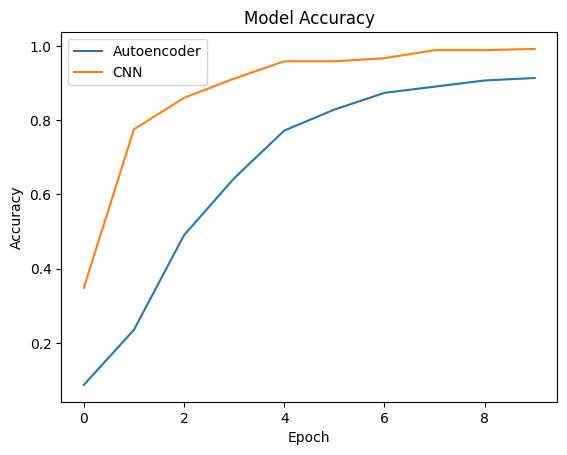

In [64]:
plt.plot(history_autoencoder.history['accuracy'])
plt.plot(history_cnn.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'CNN'], loc='upper left')
plt.show()

### Compare the performance of the autoencoder and CNN models

In [65]:
print(f'Unsupervised CNN autoencoder with supervised fine-tuning accuracy: {accuracy_autoencoder}')
print(f'Supervised CNN accuracy: {accuracy_cnn}')

Unsupervised CNN autoencoder with supervised fine-tuning accuracy: 0.8575000166893005
Supervised CNN accuracy: 0.9135000109672546
